In [1]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(magrittr)
library(lme4)
library(lsmeans)
library(caret)

Loading required package: permute

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.4     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’

In [2]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list


# Convert taxonomy info to data frame with correct taxonomy labels
taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")
tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11,
12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [3]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA"))

In [4]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125",
         "N15_A017")

ps = subset_samples(ps, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 256 samples ]
sample_data() Sample Data:       [ 256 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [5]:
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped

ps_both = subset_samples(ps_Clipped, filter_unpair=="no")
ps_both

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 191 samples ]
sample_data() Sample Data:       [ 191 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [6]:
ps_Clipped_A_P =subset_samples(ps_both, Combo=="Ambient_Placebo")
ps_Clipped_A_P

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [7]:
select =c( "Ambient_Pathogen", "NH4_Pathogen"
         )
#only disease
ps_disease =subset_samples(ps_Clipped , Combo %in% select)
ps_disease

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 79 samples ]
sample_data() Sample Data:       [ 79 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [8]:
#filter
ps_Clipped_fil = filter_taxa(ps_both, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_Clipped_fil
                             
ps_Clipped_A_P_fil = filter_taxa(ps_Clipped_A_P, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_Clipped_A_P_fil

ps_disease_fill = filter_taxa(ps_disease, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_disease_fill                                    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6403 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 6403 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6403 tips and 5710 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1255 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 1255 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1255 tips and 1211 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4284 taxa and 79 samples ]
sample_data() Sample Data:       [ 79 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 4284 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4284 tips and 3808 internal nodes ]

In [9]:
#summary of ambient and placebo
microbiome::summarize_phyloseq(ps_Clipped_A_P_fil)

Compositional = NO2

1] Min. number of reads = 124782] Max. number of reads = 539693] Total number of reads = 8748074] Average number of reads = 29160.23333333335] Median number of reads = 287037] Sparsity = 0.9526427622841976] Any OTU sum to 1 or less? NO8] Number of singletons = 09] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)010] Number of sample variables are: 62sample_namesfeaturecountsInitial_sample_IDTagstart_dateevent_datecollection_dateDateTimePointReplicateGenotypelabelNurseryLatLonglat_longorganismgeo_loc_nameenv_local_scaleenv_broad_scaleenv_mediumwaterBodycountryCodeamplicon_sequencedNutrientsDiseasedComboTank_NTank_D1Tank_D2TypeHealthOutcomeNotesSeveritySurvivorshipPairsfilter_unpairCombo_healthArchive_boxGenotype.1NH4_SusceptibilityDisease_SusceptibilityNH4_Disease_SusceptibilityExpectedSurv_diseaseSurv_nutrientssurvstd.errbarcode_labelbarcode_seqIDSequencing_RoundPlate_NamePlate_BarcodeWell_PositionSequence_NameIllumin

[[1]]
[1] "1] Min. number of reads = 12478"

[[2]]
[1] "2] Max. number of reads = 53969"

[[3]]
[1] "3] Total number of reads = 874807"

[[4]]
[1] "4] Average number of reads = 29160.2333333333"

[[5]]
[1] "5] Median number of reads = 28703"

[[6]]
[1] "7] Sparsity = 0.952642762284197"

[[7]]
[1] "6] Any OTU sum to 1 or less? NO"

[[8]]
[1] "8] Number of singletons = 0"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0"

[[10]]
[1] "10] Number of sample variables are: 62"

[[11]]
 [1] "sample_names"               "featurecounts"             
 [3] "Initial_sample_ID"          "Tag"                       
 [5] "start_date"                 "event_date"                
 [7] "collection_date"            "Date"                      
 [9] "TimePoint"                  "Replicate"                 
[11] "Genotype"                   "label"                     
[13] "Nursery"                    "Lat"                       
[15] "Long"                       "lat_long"                  
[17] "organism"                   "geo_loc_name"              
[19] "env_local_scale"            "env_broad_scale"           
[21] "env_medium"                 "waterBody"                 
[23] "countryCode"                "amplicon_sequenced"        
[25] "Nutrients"                  "Diseased"                  
[27] "Combo"                      "Tank_N"                    
[29] "Tank_D1"                    "Tank_D2"                   
[31] "Type"                       "Health"                    
[33] "Outcome"                    "Notes"                     
[35] "Severity"                   "Survivorship"              
[37] "Pairs"                      "filter_unpair"             
[39] "Combo_health"               "Archive_box"               
[41] "Genotype.1"                 "NH4_Susceptibility"        
[43] "Disease_Susceptibility"     "NH4_Disease_Susceptibility"
[45] "Expected"                   "Surv_disease"              
[47] "Surv_nutrients"             "surv"                      
[49] "std.err"                    "barcode_label"             
[51] "barcode_seq"                "ID"                        
[53] "Sequencing_Round"           "Plate_Name"                
[55] "Plate_Barcode"              "Well_Position"             
[57] "Sequence_Name"              "Illumina5_Adapter"         
[59] "Forward_Primer_Pad"         "Golay_Barcode"             
[61] "X515FB_Forward_Primer"      "Primer_For_PCR"

In [10]:
#rarefy ambient placebo
(ps_rare_A_P_fil <- phyloseq::rarefy_even_depth(ps_Clipped_A_P_fil, rngseed = 123, replace = FALSE, sample.size=12478))             


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

28OTUs were removed because they are no longer 
present in any sample after random subsampling


...



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1227 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 1227 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1227 tips and 1183 internal nodes ]

In [11]:
#rarefy treatments
ps_rare<- phyloseq::rarefy_even_depth(ps_Clipped_fil, rngseed = 123, replace = FALSE, sample.size=12478)             


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

1 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


N131-200

...

181OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [12]:
#rarefy disease samples
(ps_rare_disease <- phyloseq::rarefy_even_depth(ps_disease_fill, rngseed = 123, replace = FALSE, sample.size=17668))             


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

1 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


N131-200

...

57OTUs were removed because they are no longer 
present in any sample after random subsampling


...



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4227 taxa and 78 samples ]
sample_data() Sample Data:       [ 78 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 4227 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4227 tips and 3753 internal nodes ]

In [13]:
#combine results with metadata
adiv <- data.frame(
  "Simpson" = phyloseq::estimate_richness(ps_rare, measures = "Simpson"),
  "Shannon" = phyloseq::estimate_richness(ps_rare, measures = "Shannon"),
  "Combo" = phyloseq::sample_data(ps_rare)$Combo) %>% rownames_to_column("sample_names")
head(adiv)


adiv_AP <- data.frame(
  "Simpson" = phyloseq::estimate_richness(ps_rare_A_P_fil, measures = "Simpson"),
  "Shannon" = phyloseq::estimate_richness(ps_rare_A_P_fil, measures = "Shannon"),
  "Genotype" = phyloseq::sample_data(ps_rare_A_P_fil)$Genotype) %>% rownames_to_column("sample_names")
head(adiv_AP)

adiv_disease <- data.frame(
  "Simpson" = phyloseq::estimate_richness(ps_rare_disease, measures = "Simpson"),
  "Shannon" = phyloseq::estimate_richness(ps_rare_disease, measures = "Shannon"),
  "Outcome" = phyloseq::sample_data(ps_rare_disease)$Outcome) %>% rownames_to_column("sample_names")
head(adiv_disease)

,sample_names,Simpson,Shannon,Combo
,<chr>,<dbl>,<dbl>,<chr>
1,N10-A019,0.9136701,2.667239,NH4_Placebo
2,N11-A153,0.8914250,2.306571,NH4_Placebo
3,N115-247,0.9827763,4.329426,NH4_Pathogen
4,N12-A008,0.8949002,2.372131,NH4_Placebo
5,N13-A038,0.9063230,2.582413,NH4_Placebo
6,N14-A040,0.8887895,2.243536,NH4_Placebo


,sample_names,Simpson,Shannon,Genotype
,<chr>,<dbl>,<dbl>,<chr>
1,N211-A191,0.8927463,2.354247,FM19
2,N215-250,0.9032232,2.580987,FM6
3,N220-334,0.8902584,2.286668,FM9
4,N102-A012,0.8599785,2.026386,Kelsey-1
5,N103-A028,0.8679504,2.169076,Cooper-9
6,N104-276,0.8593688,2.035665,FM14


,sample_names,Simpson,Shannon,Outcome
,<chr>,<dbl>,<dbl>,<chr>
1,N115-247,0.9826508,4.324769,Unhealthy
2,N265-A066,0.8898346,2.264700,Unaffected
3,N266-A104,0.9825110,4.556490,Unaffected
4,N268-A180,0.9042880,2.584862,Unaffected
5,N269-A181,0.9002519,2.492272,Unaffected
6,N270-A182,0.8955769,2.407258,Unaffected


In [14]:
#different transformations 
adiv_trans =adiv_AP %>%
mutate(Shannon_trans =  (Shannon - mean(Shannon)) / sd(Shannon))

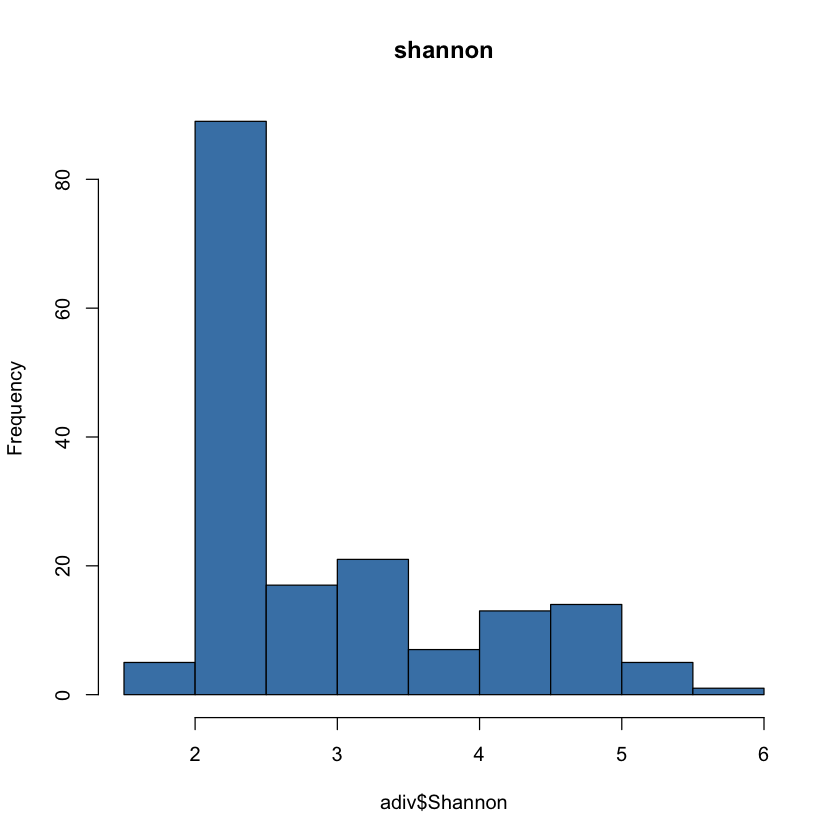


	Shapiro-Wilk normality test

data:  adiv$Shannon
W = 0.81451, p-value = 1.636e-13


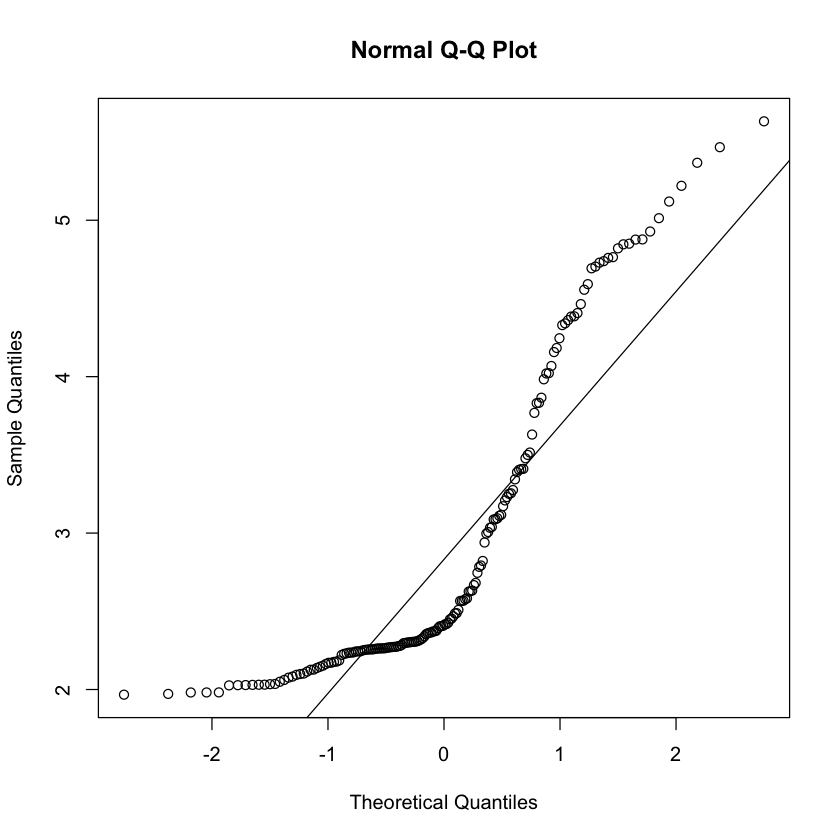

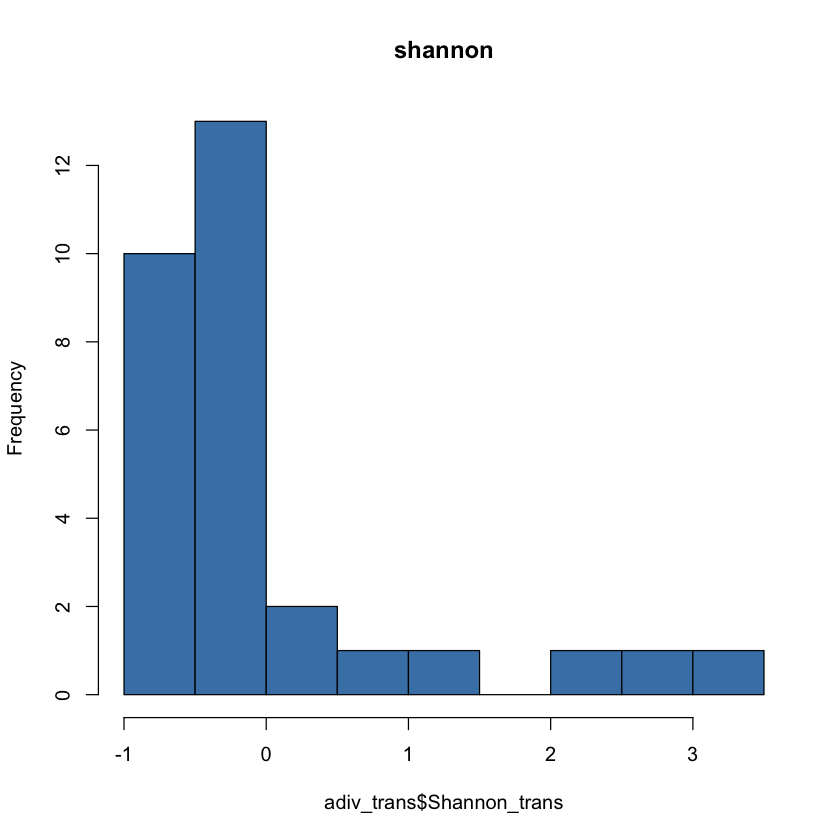


	Shapiro-Wilk normality test

data:  adiv_trans$Shannon_trans
W = 0.645, p-value = 2.71e-07


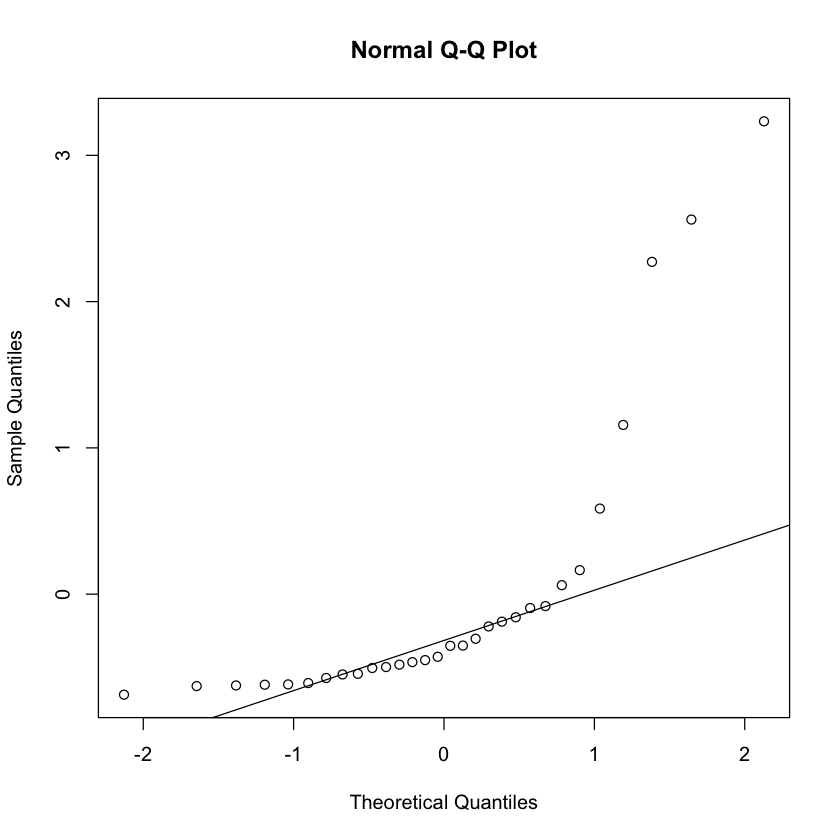

In [15]:
#view and test for normality
hist(adiv$Shannon, col='steelblue', main='shannon')
qqnorm(adiv$Shannon)
qqline(adiv$Shannon)
shapiro.test(adiv$Shannon)


hist(adiv_trans$Shannon_trans, col='steelblue', main='shannon')
qqnorm(adiv_trans$Shannon_trans)
qqline(adiv_trans$Shannon_trans)
shapiro.test(adiv_trans$Shannon_trans)

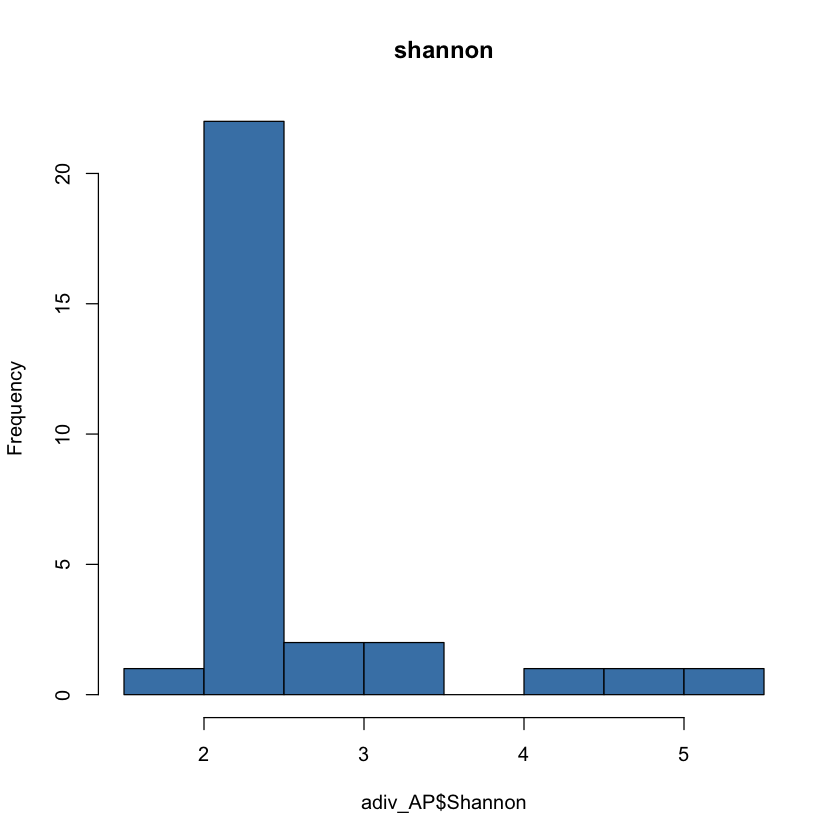


	Shapiro-Wilk normality test

data:  adiv_AP$Shannon
W = 0.645, p-value = 2.71e-07


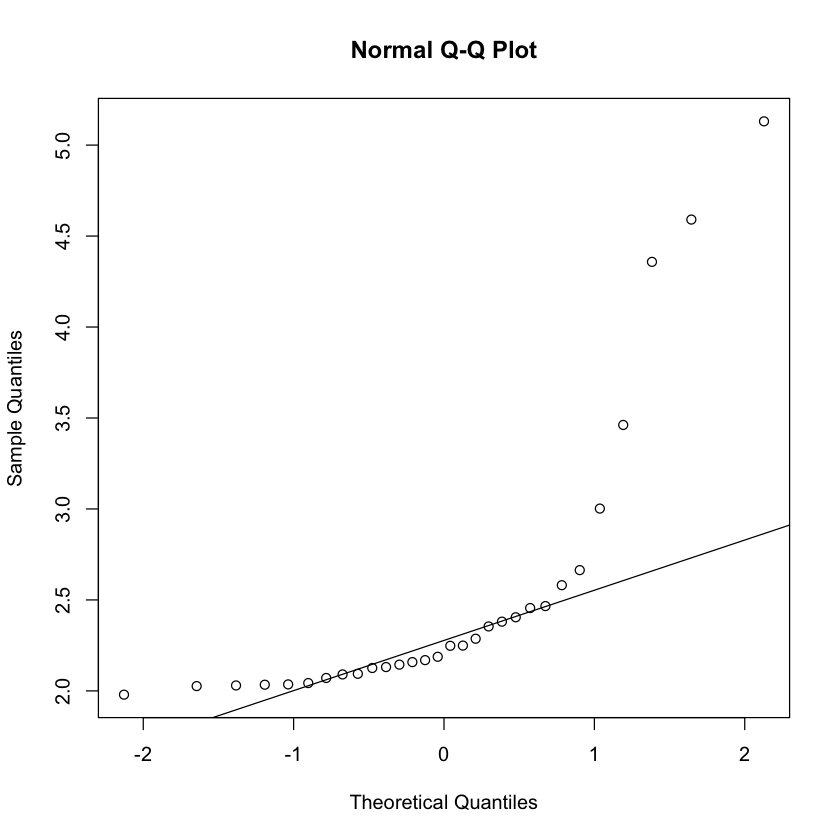

In [16]:
hist(adiv_AP$Shannon, col='steelblue', main='shannon')
qqnorm(adiv_AP$Shannon)
qqline(adiv_AP$Shannon)
shapiro.test(adiv_AP$Shannon)


In [17]:
head(adiv_AP)
head(meta)

df_AP <- meta %>%
  right_join(adiv_AP,
            by = "sample_names") 
head(df_AP)




head(adiv)
df_clip <- meta %>%
  right_join(adiv,
            by = "sample_names") 
head(df_clip)



adiv_disease <- meta %>%
  right_join(adiv,
            by = "sample_names") 
head(adiv_disease)

,sample_names,Simpson,Shannon,Genotype
,<chr>,<dbl>,<dbl>,<chr>
1,N211-A191,0.8927463,2.354247,FM19
2,N215-250,0.9032232,2.580987,FM6
3,N220-334,0.8902584,2.286668,FM9
4,N102-A012,0.8599785,2.026386,Kelsey-1
5,N103-A028,0.8679504,2.169076,Cooper-9
6,N104-276,0.8593688,2.035665,FM14


,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,collection_date,Date,TimePoint,Replicate,⋯,Sequencing_Round,Plate_Name,Plate_Barcode,Well_Position,Sequence_Name,Illumina5_Adapter,Forward_Primer_Pad,Golay_Barcode,X515FB_Forward_Primer,Primer_For_PCR
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
N5-FACs,N5-FACs,23177,5,FACs,8/19/20,10/19/20,10/19/20,19-Oct,1,NA,⋯,2,2,11705851,B11,515rcbc118,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,CTACAGGGTCTC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTCTACAGGGTCTCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA
N5-FACs-R2,N5-FACs-R2,15770,5,FACs,8/19/20,10/19/20,10/19/20,19-Oct,1,NA,⋯,2,2,11705851,F01,515rcbc156,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,ATATGTTCTCAA,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTATATGTTCTCAATATGGTAATTGTGTGYCAGCMGCCGCGGTAA
N60-A056,N60-A056,75497,60,A056,8/19/20,10/30/20,10/30/20,30-Oct,8,NA,⋯,1,1,11706365,C06,515rcbc29,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA
N85-A055,N85-A055,31470,85,A055,8/19/20,11/3/20,11/3/20,3-Nov,12,r1_w,⋯,1,1,11706365,D09,515rcbc44,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA
N95-215,N95-215,26442,95,215,8/19/20,11/4/20,11/4/20,4-Nov,13,r1_w,⋯,1,1,11706365,D10,515rcbc45,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA
N96-231,N96-231,36569,96,231,8/19/20,11/4/20,11/4/20,4-Nov,13,NA,⋯,1,1,11706365,E10,515rcbc57,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA


,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,collection_date,Date,TimePoint,Replicate,⋯,Well_Position,Sequence_Name,Illumina5_Adapter,Forward_Primer_Pad,Golay_Barcode,X515FB_Forward_Primer,Primer_For_PCR,Simpson,Shannon,Genotype.y
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,N85-A055,31470,85,A055,8/19/20,11/3/20,11/3/20,3-Nov,12,r1_w,⋯,D09,515rcbc44,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8595712,2.042988,Acerv2
2,N94-A091,78835,94,A091,8/19/20,11/4/20,11/4/20,4-Nov,13,r1_w,⋯,C10,515rcbc33,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.9820100,4.590731,U44
3,N103-A028,38507,103,A028,8/19/20,11/5/20,11/5/20,5-Nov,14,r1_w,⋯,D11,515rcbc46,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8679504,2.169076,Cooper-9
4,N104-276,20691,104,276,8/19/20,11/5/20,11/5/20,5-Nov,14,r1_w,⋯,E11,515rcbc58,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8593688,2.035665,FM14
5,N121-A160,29131,121,A160,8/19/20,11/5/20,11/5/20,5-Nov,14,r1_w,⋯,F01,515rcbc156,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,ATATGTTCTCAA,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTATATGTTCTCAATATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8589148,2.029839,K2
6,N102-A012,13157,102,A012,8/19/20,11/5/20,11/5/20,5-Nov,14,r1_w,⋯,C11,515rcbc34,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8599785,2.026386,Kelsey-1


,sample_names,Simpson,Shannon,Combo
,<chr>,<dbl>,<dbl>,<chr>
1,N10-A019,0.9136701,2.667239,NH4_Placebo
2,N11-A153,0.8914250,2.306571,NH4_Placebo
3,N115-247,0.9827763,4.329426,NH4_Pathogen
4,N12-A008,0.8949002,2.372131,NH4_Placebo
5,N13-A038,0.9063230,2.582413,NH4_Placebo
6,N14-A040,0.8887895,2.243536,NH4_Placebo


,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,collection_date,Date,TimePoint,Replicate,⋯,Well_Position,Sequence_Name,Illumina5_Adapter,Forward_Primer_Pad,Golay_Barcode,X515FB_Forward_Primer,Primer_For_PCR,Simpson,Shannon,Combo.y
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,N85-A055,31470,85,A055,8/19/20,11/3/20,11/3/20,3-Nov,12,r1_w,⋯,D09,515rcbc44,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8587990,2.033956,Ambient_Placebo
2,N95-215,26442,95,215,8/19/20,11/4/20,11/4/20,4-Nov,13,r1_w,⋯,D10,515rcbc45,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8724933,2.256677,NH4_Placebo
3,N96-231,36569,96,231,8/19/20,11/4/20,11/4/20,4-Nov,13,NA,⋯,E10,515rcbc57,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8583830,2.027697,NH4_Placebo
4,N99-A036,75575,99,A036,8/19/20,11/4/20,11/4/20,4-Nov,13,NA,⋯,H10,515rcbc93,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.9931258,5.220101,NH4_Placebo
5,N94-A091,78835,94,A091,8/19/20,11/4/20,11/4/20,4-Nov,13,r1_w,⋯,C10,515rcbc33,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.9820861,4.591403,Ambient_Placebo
6,N108-A188,44424,108,A188,8/19/20,11/5/20,11/5/20,5-Nov,14,NA,⋯,A12,515rcbc11,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8664144,2.170875,NH4_Placebo


,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,collection_date,Date,TimePoint,Replicate,⋯,Well_Position,Sequence_Name,Illumina5_Adapter,Forward_Primer_Pad,Golay_Barcode,X515FB_Forward_Primer,Primer_For_PCR,Simpson,Shannon,Combo.y
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,N85-A055,31470,85,A055,8/19/20,11/3/20,11/3/20,3-Nov,12,r1_w,⋯,D09,515rcbc44,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8587990,2.033956,Ambient_Placebo
2,N95-215,26442,95,215,8/19/20,11/4/20,11/4/20,4-Nov,13,r1_w,⋯,D10,515rcbc45,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8724933,2.256677,NH4_Placebo
3,N96-231,36569,96,231,8/19/20,11/4/20,11/4/20,4-Nov,13,NA,⋯,E10,515rcbc57,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8583830,2.027697,NH4_Placebo
4,N99-A036,75575,99,A036,8/19/20,11/4/20,11/4/20,4-Nov,13,NA,⋯,H10,515rcbc93,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.9931258,5.220101,NH4_Placebo
5,N94-A091,78835,94,A091,8/19/20,11/4/20,11/4/20,4-Nov,13,r1_w,⋯,C10,515rcbc33,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.9820861,4.591403,Ambient_Placebo
6,N108-A188,44424,108,A188,8/19/20,11/5/20,11/5/20,5-Nov,14,NA,⋯,A12,515rcbc11,AATGATACGGCGACCACCGAGATCTACACGCT,TATGGTAATT,AGCCTTCGTCGC,GTGYCAGCMGCCGCGGTAA,AATGATACGGCGACCACCGAGATCTACACGCTAGCCTTCGTCGCTATGGTAATTGTGTGYCAGCMGCCGCGGTAA,0.8664144,2.170875,NH4_Placebo


## Genotype differences

boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: inverse.gaussian  ( log )
Formula: Shannon ~ -1 + Genotype.y + (1 | TimePoint)
   Data: df_AP

      AIC       BIC    logLik -2*log(L)  df.resid 
     41.1      57.9      -8.6      17.1        18 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8849 -0.4201 -0.0573  0.3173  3.6467 

Random effects:
 Groups    Name        Variance Std.Dev.
 TimePoint (Intercept) 0.000000 0.00000 
 Residual              0.007121 0.08439 
Number of obs: 30, groups:  TimePoint, 8

Fixed effects:
                   Estimate Std. Error t value Pr(>|z|)    
Genotype.yAcerv2    0.76108    0.06891  11.044   <2e-16 ***
Genotype.yCooper-9  0.79257    0.08574   9.244   <2e-16 ***
Genotype.yElkhorn   1.05274    0.07973  13.203   <2e-16 ***
Genotype.yFM14      0.73639    0.05895  12.492   <2e-16 ***
Genotype.yFM19      0.82202    0.07105  11.570   <2e-16 ***
Genotype.yFM6       0.93602    0.07521  1

 contrast                estimate     SE  df z.ratio p.value
 Acerv2 - (Cooper-9)     -0.03149 0.1100 Inf  -0.286  1.0000
 Acerv2 - Elkhorn        -0.29166 0.1050 Inf  -2.768  0.1476
 Acerv2 - FM14            0.02469 0.0907 Inf   0.272  1.0000
 Acerv2 - FM19           -0.06094 0.0990 Inf  -0.616  0.9998
 Acerv2 - FM6            -0.17494 0.1020 Inf  -1.715  0.7873
 Acerv2 - FM9            -0.07610 0.0994 Inf  -0.766  0.9990
 Acerv2 - K2              0.04304 0.1080 Inf   0.400  1.0000
 Acerv2 - (Kelsey-1)     -0.00776 0.0976 Inf  -0.079  1.0000
 Acerv2 - U44            -0.63673 0.1070 Inf  -5.942  <.0001
 (Cooper-9) - Elkhorn    -0.26017 0.1170 Inf  -2.222  0.4413
 (Cooper-9) - FM14        0.05618 0.1040 Inf   0.540  0.9999
 (Cooper-9) - FM19       -0.02945 0.1110 Inf  -0.264  1.0000
 (Cooper-9) - FM6        -0.14345 0.1140 Inf  -1.258  0.9627
 (Cooper-9) - FM9        -0.04461 0.1120 Inf  -0.399  1.0000
 (Cooper-9) - K2          0.07454 0.1190 Inf   0.626  0.9998
 (Cooper-9) - (Kelsey-1)

Genotype.yAcerv2 Genotype.yCooper-9  Genotype.yElkhorn     Genotype.yFM14 
          2.140583           2.209068           2.865501           2.088379 
    Genotype.yFM19      Genotype.yFM6      Genotype.yFM9       Genotype.yK2 
          2.275097           2.549816           2.309837           2.050398 
Genotype.yKelsey-1      Genotype.yU44 
          2.157261           4.046339

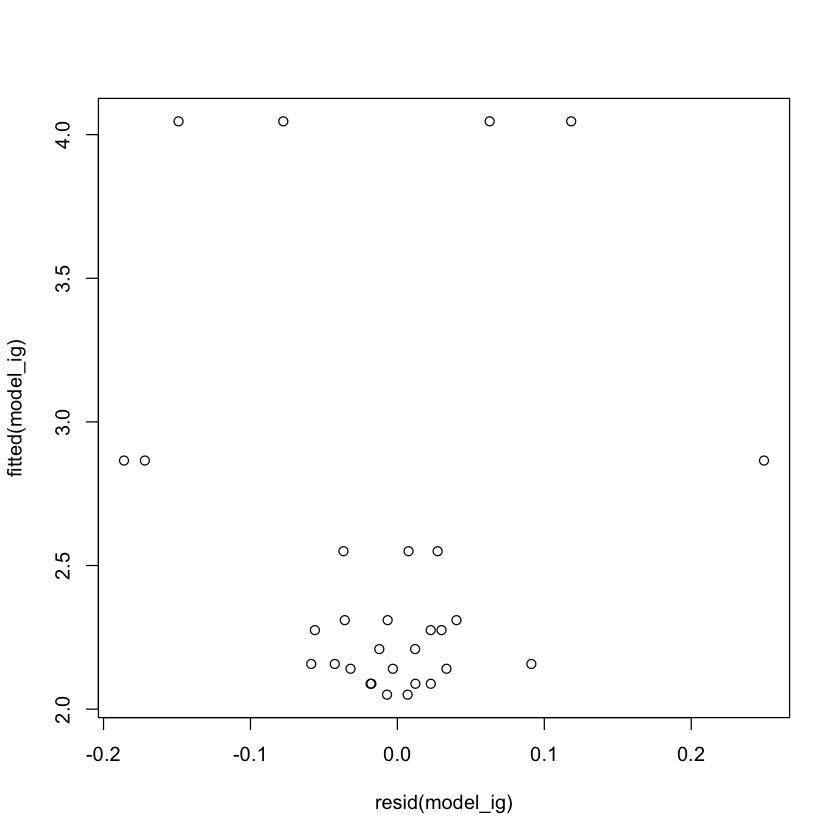

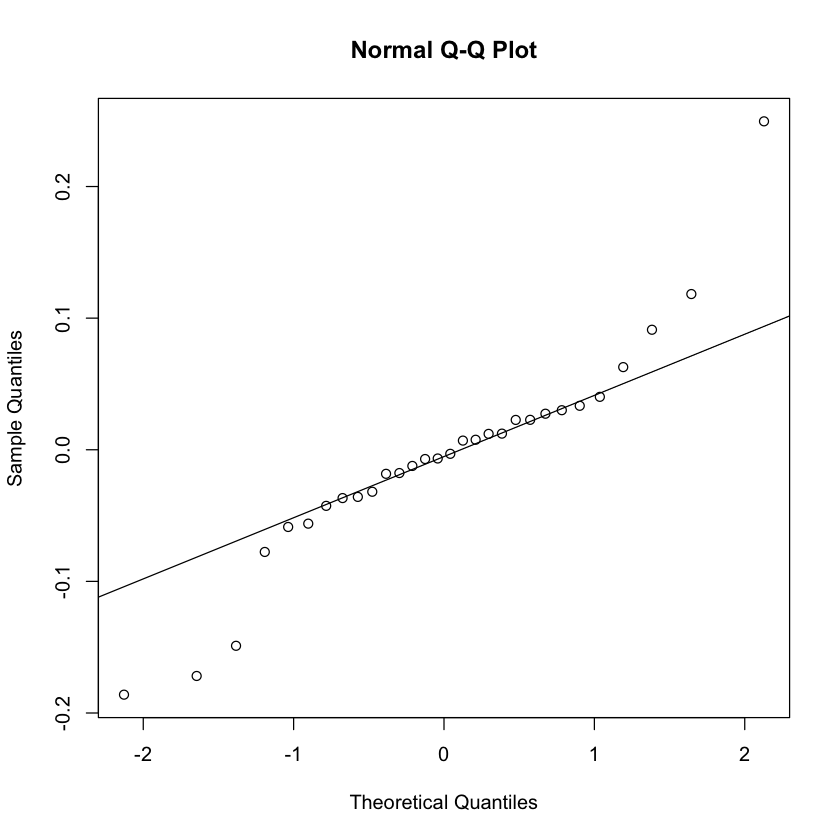

In [18]:


# Fit the model using the Inverse Gaussian family with a log link
model_ig <- glmer(Shannon ~ -1 + Genotype.y + (1 | TimePoint), 
                  data = df_AP, 
                  family = inverse.gaussian(link = "log"))

# Check the summary of the model
summary(model_ig)


emmeans_genotype <- emmeans(model_ig, "Genotype.y")

# Perform pairwise comparisons with Tukey adjustment
pairwise_comparisons <- pairs(emmeans_genotype, adjust = "tukey")

# Print the pairwise comparisons results
print(pairwise_comparisons)

#Shannon diversity values per genotype
exp(fixef(model_ig))
#Plot residuals vs. fitted values to check for any patterns (should be random scatter)
plot(resid(model_ig), fitted(model_ig))
#check gamma distribution 
qqnorm(resid(model_ig))
qqline(resid(model_ig))

## Treatment differences

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: inverse.gaussian  ( log )
Formula: Shannon ~ Combo.y + (1 | Genotype)
   Data: df_clip

      AIC       BIC    logLik -2*log(L)  df.resid 
    314.6     333.5    -151.3     302.6       166 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2713 -0.6927 -0.1627  0.3438  4.1032 

Random effects:
 Groups   Name        Variance Std.Dev.
 Genotype (Intercept) 0.01368  0.1170  
 Residual             0.01813  0.1346  
Number of obs: 172, groups:  Genotype, 10

Fixed effects:
                       Estimate Std. Error t value Pr(>|z|)    
(Intercept)             1.22789    0.09021  13.611  < 2e-16 ***
Combo.yAmbient_Placebo -0.30256    0.05278  -5.732 9.90e-09 ***
Combo.yNH4_Pathogen    -0.03474    0.05029  -0.691     0.49    
Combo.yNH4_Placebo     -0.26229    0.04663  -5.625 1.86e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed E

 contrast                           estimate     SE  df z.ratio p.value
 Ambient_Pathogen - Ambient_Placebo   0.3026 0.0528 Inf   5.732  <.0001
 Ambient_Pathogen - NH4_Pathogen      0.0347 0.0503 Inf   0.691  0.9007
 Ambient_Pathogen - NH4_Placebo       0.2623 0.0466 Inf   5.625  <.0001
 Ambient_Placebo - NH4_Pathogen      -0.2678 0.0455 Inf  -5.891  <.0001
 Ambient_Placebo - NH4_Placebo       -0.0403 0.0418 Inf  -0.963  0.7705
 NH4_Pathogen - NH4_Placebo           0.2276 0.0388 Inf   5.865  <.0001

Results are given on the log (not the response) scale. 
P value adjustment: tukey method for comparing a family of 4 estimates 


(Intercept) Combo.yAmbient_Placebo    Combo.yNH4_Pathogen 
             3.4140094              0.7389216              0.9658592 
    Combo.yNH4_Placebo 
             0.7692857

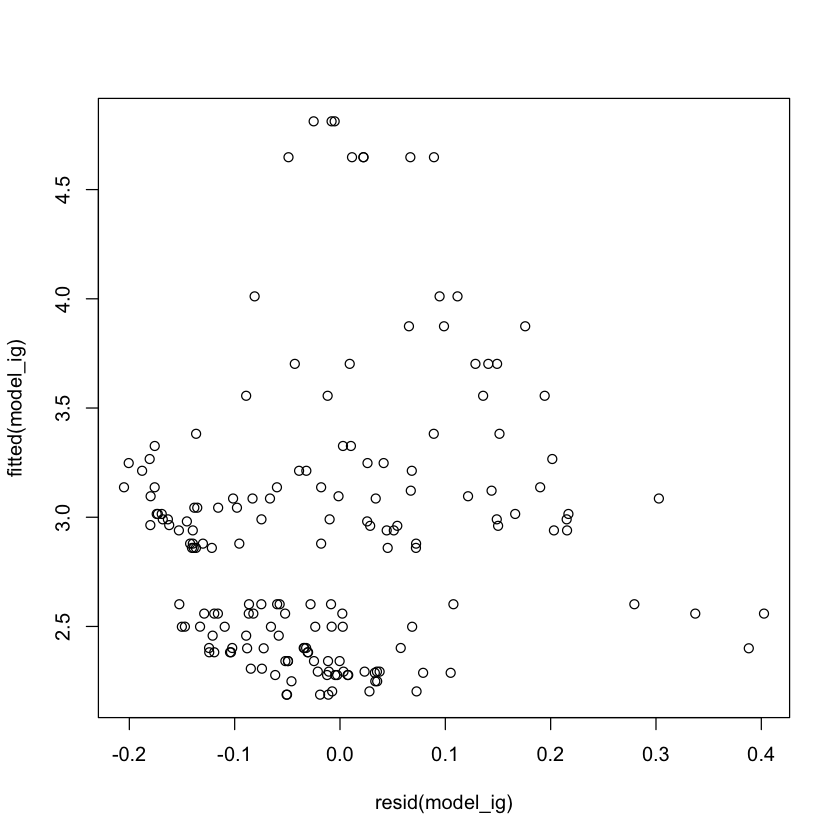

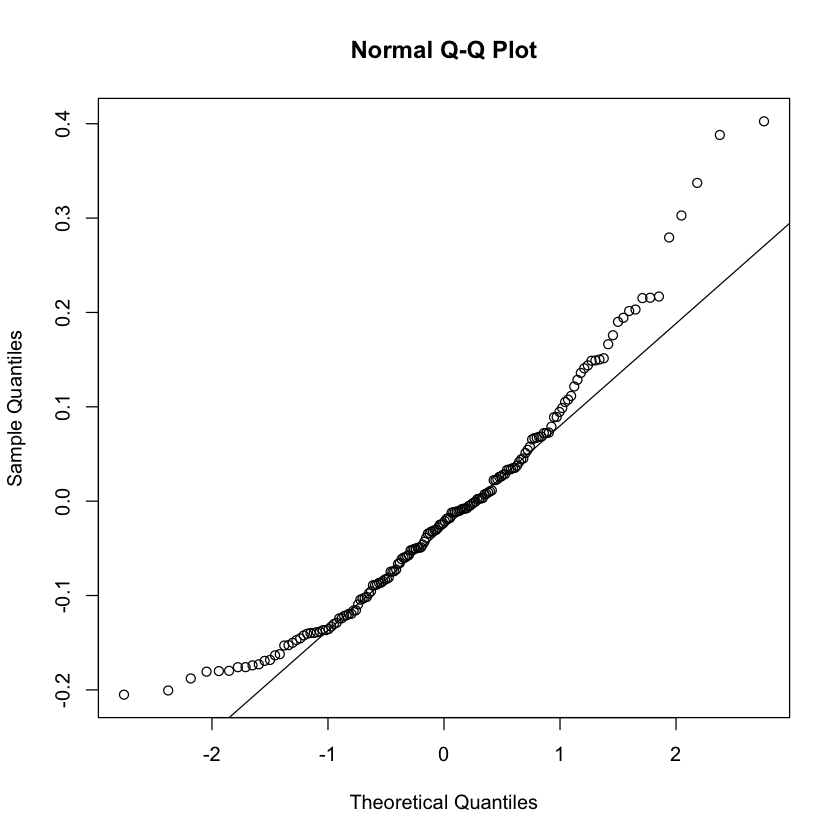

In [19]:
# Fit the model using the Inverse Gaussian family with a log link
model_ig <- glmer(Shannon ~ Combo.y + (1 | Genotype), 
                  data = df_clip, 
                  family = inverse.gaussian(link = "log"))

# Check the summary of the model
summary(model_ig)


emmeans_genotype <- emmeans(model_ig, "Combo.y")

# Perform pairwise comparisons with Tukey adjustment
pairwise_comparisons <- pairs(emmeans_genotype, adjust = "tukey")

# Print the pairwise comparisons results
print(pairwise_comparisons)

#Shannon diversity values per genotype
exp(fixef(model_ig))
#Plot residuals vs. fitted values to check for any patterns (should be random scatter)
plot(resid(model_ig), fitted(model_ig))
#check gamma distribution 
qqnorm(resid(model_ig))
qqline(resid(model_ig))

## Outcome

In [20]:
df_clip_clean <- df_clip %>% filter(Survivorship!="NA")


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: inverse.gaussian  ( log )
Formula: Shannon ~ Outcome + (1 | Genotype)
   Data: adiv_disease

      AIC       BIC    logLik -2*log(L)  df.resid 
    256.5     272.2    -123.2     246.5       167 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5560 -0.5800 -0.1362  0.2693  4.6300 

Random effects:
 Groups   Name        Variance Std.Dev.
 Genotype (Intercept) 0.01183  0.1088  
 Residual             0.01289  0.1135  
Number of obs: 172, groups:  Genotype, 10

Fixed effects:
                    Estimate Std. Error t value Pr(>|z|)    
(Intercept)        0.9152051  0.0861638  10.622   <2e-16 ***
OutcomeUnaffected -0.0003811  0.0344307  -0.011    0.991    
OutcomeUnhealthy   0.3605487  0.0369281   9.764   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) OtcmUnf
OtcmUnffctd -0.276        
OtcmUnhlt

 contrast                estimate     SE  df z.ratio p.value
 Healthy - Unaffected    0.000381 0.0344 Inf   0.011  0.9999
 Healthy - Unhealthy    -0.360549 0.0369 Inf  -9.764  <.0001
 Unaffected - Unhealthy -0.360930 0.0314 Inf -11.513  <.0001

Results are given on the log (not the response) scale. 
P value adjustment: tukey method for comparing a family of 3 estimates 


(Intercept) OutcomeUnaffected  OutcomeUnhealthy 
         2.497287          0.999619          1.434116

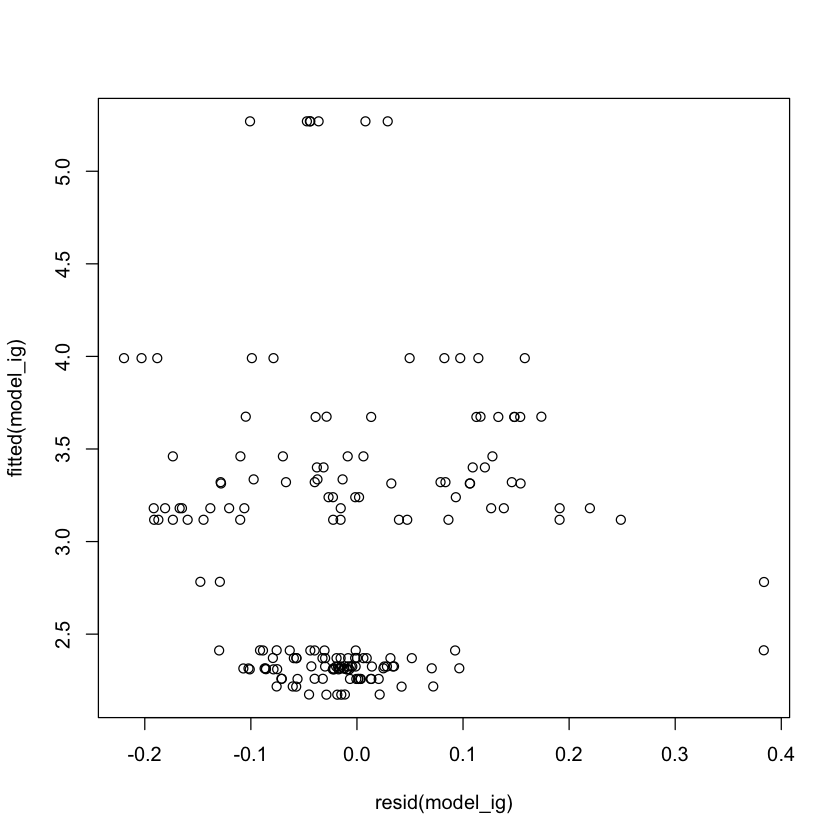

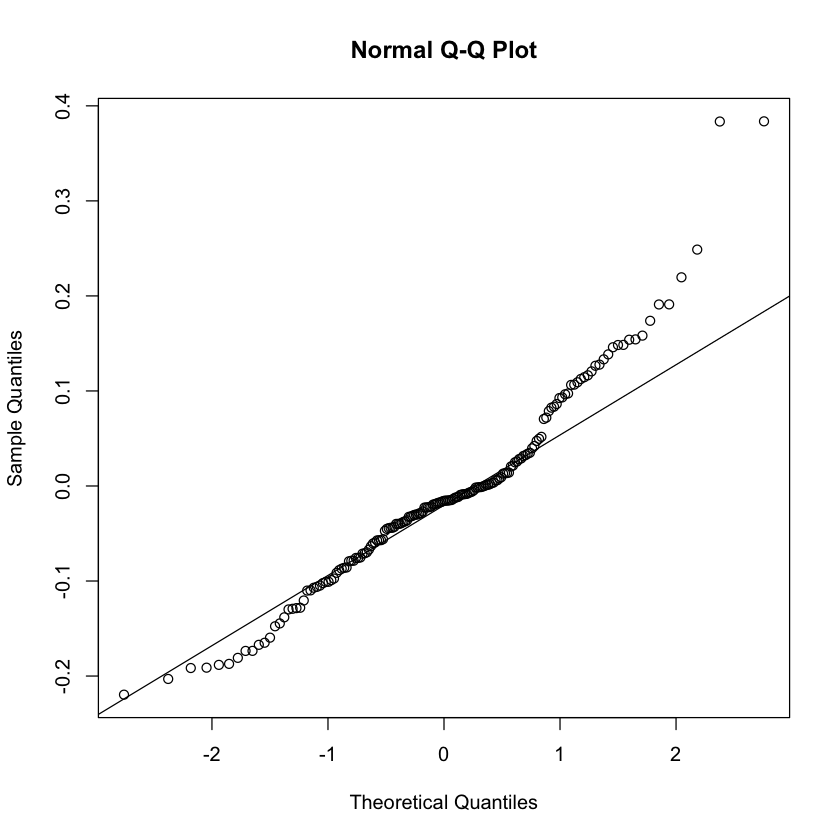

In [21]:
# Fit the model using the Inverse Gaussian family with a log link
model_ig <- glmer(Shannon ~ Outcome  + 
                  (1 | Genotype), 
                  data = adiv_disease, 
                  family = inverse.gaussian(link = "log"),
              )

# Check the summary of the model
summary(model_ig)


emmeans_genotype <- emmeans(model_ig, "Outcome")

# Perform pairwise comparisons with Tukey adjustment
pairwise_comparisons <- pairs(emmeans_genotype, adjust = "tukey")

# Print the pairwise comparisons results
print(pairwise_comparisons)

#Shannon diversity values per genotype
exp(fixef(model_ig))
#Plot residuals vs. fitted values to check for any patterns (should be random scatter)
plot(resid(model_ig), fitted(model_ig))
#check gamma distribution 
qqnorm(resid(model_ig))
qqline(resid(model_ig))

In [22]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.6.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] caret_7.0-1       lattice_0.22-7    lsmeans_2.30-2    emmeans_1.11.0   
 [5] lme4_1.1-37       Matrix_1.7-3      magrittr_2.0.4    lubridate_1.9.4  
 [9] forcats_1.0.0     stringr_1.5.1     dplyr_1.1.4       purrr_1.0.4      
[13] readr_2.1.5       tidyverse_2.0.0   microbiome_1.30.0 phyloseq_1.52.0  
[17] vegan_2.7-1       permute_0.9-7     ggplot2_4.0.0     tibble_3.3.0     
[21] tidyr_1.3.1       qiime2R_0.